In [12]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

In [13]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'..','experiments'))
sketch_dir = os.path.abspath(os.path.join(os.getcwd(),'..','sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [14]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'pilot2_bonusmeter'

In [15]:
coll.distinct('iterationName')

[u'testing', u'pilot2_bonusmeter']

In [6]:
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}, {'time':{'$gt':1531160581750, '$lt': 1531161932801}}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

40 stroke records in the database.
136 clickedObj records in the database.


In [16]:
## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
#megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe #+ megsano

In [22]:
def get_complete_and_valid_games(games,coll,researchers=['A1MMCS8S8CTWKU']):
    '''
    Input: Accepts list of gameIDs that are in the database, and a list of the researcher worker ID's
    Output: Returns list of complete and valid gameID, defined as: 
        (1) complete games (correct number of trials==40)
        (2) there were two real MTurk workers participating (i.e., not a researcher or undefined worker)

    '''
    complete_games = []
    for i, game in enumerate(games):
        num_clicks = coll.find({'$and': [{'gameid':game},{'eventType':'clickedObj'}]}).count()
        ## check to make sure there were two real mturk workers participating who were not researchers
        real_workers = False
        viewer = coll.find({'$and': [{'gameid':game},{'eventType':'clickedObj'}]}).distinct('workerId')
        sketcher = coll.find({'$and': [{'gameid':game},{'eventType':'clickedObj'}]}).distinct('workerId')
        viewer_is_researcher = viewer in researchers
        sketcher_is_researcher = sketcher in researchers  
        try:
            viewer_check = (len(viewer[0])>10) & len(viewer)==1 ## length of workerID string should be long enough & there should be exactly one viewer
            sketcher_check = (len(sketcher[0])>10) & len(sketcher)==1 ## length of workerID string should be long enough & there should be exactly one viewer    
            if (viewer_check) & (sketcher_check) & (not viewer_is_researcher) & (not sketcher_is_researcher):
                real_workers = True
                print game, viewer_check, sketcher_check, viewer_is_researcher, sketcher_is_researcher
        except:
            print 'There was something wrong with this game {}'.format(game)

        ## check to make sure there are the correct number of clicked Obj events, which should equal the number of trials in the game   
        finished_game = False
        print num_clicks
        if num_clicks == 40:
            finished_game = True

        ## now if BOTH of the above conditions are true, bother to analyze them
        if (real_workers) & (finished_game):
            complete_games.append(game)
    print 'There are {} complete games in total.'.format(len(complete_games))
    return complete_games

In [23]:
## get list of all candidate games
games = coll.distinct('gameid')

## get list of complete and valid games
complete_games = get_complete_and_valid_games(games,coll,researchers=researchers)

9
32
2
1
2
1
5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9 True True False False
32
There was something wrong with this game 2909-8200b9a1-435f-4c08-b71b-04bd71508910
0
8283-9b48bed2-3a8c-45ae-b706-649231363252 True True False False
32
5428-1c065c92-f2c0-4c0f-bf37-9a7bc82fb832 True True False False
32
40
There are 0 complete games in total.


In [21]:
complete_games

[]

In [7]:
# # print unique gameid's
# unique_gameids = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}, {'time':{'$gt':1531160581750, '$lt': 1531161932801}}]}).sort('time').distinct('gameid')
# print map(str,unique_gameids)

# # filter out  records that match researcher ID's
# jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV']
# hawkrobe = ['A1BOIDKD33QSDK']
# #megsano = ['A1DVQQLVZR7W6I']
# researchers = jefan + hawkrobe #+ megsano 
# workers = [i for i in coll.find({'iterationName':iterationName}).distinct('workerId') if i not in researchers]

['1602-f09f5dc8-0f6a-46ab-9e09-ab12c700e9b5']


NameError: name 'megsano' is not defined

In [20]:
# valid_gameids = []
# for i,g in enumerate(unique_gameids):
#     W = coll.find({ '$and': [{'gameid': g}]}).distinct('workerId')
#     for w in W:
#         if w in workers:
#             X = coll.find({ '$and': [{'workerId': w}, {'gameid': g}]}).distinct('trialNum')
#             eventType = coll.find({ '$and': [{'workerId': w}]}).distinct('eventType')
#             print i, w[:4], len(X), str(eventType[0])
#             if (str(eventType[0])=='clickedObj') & (len(X)==32):
#                 valid_gameids.append(g)
# print '   ===========   '
# t
# # filter if the pair clearly cheated
# cheaty = ['0766-fcb90e7e-bf4a-4a46-b6d6-3165b6c12b88','7024-8ac78089-539a-428b-9d0e-b52c71a0a1b4']
# valid_gameids = [i for i in valid_gameids if i not in cheaty]

# print str(len(valid_gameids)) + ' valid gameIDs (# complete games).'

0  40 clickedObj
0 valid gameIDs (# complete games).


In [213]:
TrialNum = []
GameID = []
Condition = []
Target = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Repetition = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = []

for g in valid_gameids:
    print 'Analyzing game: ', g

    X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
    Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

    for t in X:
        targetname = t['intendedName']
        Repetition.append(t['repetition'])
        distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
        full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
        ns = y.count()
        numStrokes.append(ns)
        drawDuration.append((y.__getitem__(ns-1)['time'] - y.__getitem__(0)['time'])/1000) # in seconds
        ls = [len(_y['svgData']) for _y in y]
        svgStringLength.append(reduce(lambda x, y: x + y, ls))
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
        num_curves = [len([m.start() for m in re.finditer('c', _y['svgData'])]) for _y in y]
        numCurvesPerSketch.append(reduce(lambda x, y: x + y, num_curves))
        numCurvesPerStroke.append(reduce(lambda x, y: x + y, num_curves)/ns)
        svgStringLengthPerStroke.append(reduce(lambda x, y: x + y, ls)/ns)
        svgStringStd.append(np.std(ls))
    #     ## aggregate game metadata
        TrialNum.append(t['trialNum'])
        GameID.append(t['gameid'])        
        Target.append(targetname)
        Condition.append(t['condition'])
        Response.append(t['clickedName'])
        Outcome.append(t['correct'])
        Distractor1.append(distractors[0])
        Distractor2.append(distractors[1])
        Distractor3.append(distractors[2])  
    



Analyzing game:  5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9


In [243]:
GameID,TrialNum,Condition, Target, Repetition, drawDuration, Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd = map(np.array, \
[GameID,TrialNum,Condition, Target, Repetition, drawDuration,Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd])    

Repetition = map(int,Repetition)

D = pd.DataFrame([GameID,TrialNum,Condition, Target, Repetition, drawDuration,Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd], index = ['gameID','trialNum','condition', 'target', 'repetition', 'drawDuration','outcome', 'response', 'numStrokes', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd'])
D = D.transpose()

In [245]:
D.groupby('target')['target'].count()

target
basset             7
bloodhound         7
bullmastiff        7
chihuahua          7
doberman           1
goldenretriever    1
pug                1
weimaraner         1
Name: target, dtype: int64

In [216]:
# get summary statistics
all_games = np.unique(D.loc["gameID"])
repeated_strokes = []
control_strokes = []
repeated_svgLength = []
control_svgLength = []
repeated_svgStd = []
control_svgStd = []
repeated_svgLengthPS = []
control_svgLengthPS = []
repeated_drawDuration = []
control_drawDuration = []
repeated_accuracy = []
control_accuracy = []
criteria_repeated = (D.loc['gameID'] == game) & (D.loc['condition']=='repeated')
criteria_control = (D.loc['gameID'] == game) & (D.loc['condition']=='control')
for game in all_games:    
    repeated_strokes.append((D[(criteria_repeated).index[criteria_repeated]]).loc['numStrokes'].mean()) 
    control_strokes.append((D[(criteria_control).index[criteria_control]]).loc['numStrokes'].mean()) 
    repeated_svgLength.append((D[(criteria_repeated).index[criteria_repeated]]).loc['svgStringLength'].mean())
    control_svgLength.append((D[(criteria_control).index[criteria_control]]).loc['svgStringLength'].mean())
    repeated_svgStd.append((D[(criteria_repeated).index[criteria_repeated]]).loc['svgStringStd'].mean())
    control_svgStd.append((D[(criteria_control).index[criteria_control]]).loc['svgStringStd'].mean())
    repeated_svgLengthPS.append((D[(criteria_repeated).index[criteria_repeated]]).loc['svgStringLengthPerStroke'].mean())
    control_svgLengthPS.append((D[(criteria_control).index[criteria_control]]).loc['svgStringLengthPerStroke'].mean())
    repeated_drawDuration.append((D[(criteria_repeated).index[criteria_repeated]]).loc['drawDuration'].mean())
    control_drawDuration.append((D[(criteria_control).index[criteria_control]]).loc['drawDuration'].mean())
    repeated_accuracy.append((D[(criteria_repeated).index[criteria_repeated]]).loc['outcome'].mean())
    control_accuracy.append((D[(criteria_control).index[criteria_control]]).loc['outcome'].mean())
    
repeated_strokes, control_strokes, repeated_svgLength, control_svgLength, \
repeated_svgStd, control_svgStd, repeated_svgLengthPS, control_svgLengthPS, \
repeated_drawDuration, control_drawDuration, repeated_accuracy, control_accuracy = map(np.array, \
[repeated_strokes, control_strokes, repeated_svgLength, control_svgLength,\
 repeated_svgStd, control_svgStd, repeated_svgLengthPS, control_svgLengthPS, \
repeated_drawDuration, control_drawDuration, repeated_accuracy, control_accuracy])

 # analysis across repetitions

In [217]:
criteria_repeated = (D.loc['gameID'] == game) & (D.loc['condition']=='repeated')
repeated = (D[(criteria_repeated).index[criteria_repeated]])
repeated

,1,4,6,7,8,9,10,11,12,13,...,22,23,24,25,26,27,28,29,30,31
gameID,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,...,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9,5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9
trialNum,2,5,7,8,9,10,11,12,13,14,...,23,24,25,26,27,28,29,30,31,32
condition,repeated,repeated,repeated,repeated,repeated,repeated,repeated,repeated,repeated,repeated,...,repeated,repeated,repeated,repeated,repeated,repeated,repeated,repeated,repeated,repeated
target,basset,chihuahua,bloodhound,bullmastiff,chihuahua,bloodhound,basset,bullmastiff,bullmastiff,bloodhound,...,bloodhound,basset,bullmastiff,bloodhound,basset,chihuahua,basset,bullmastiff,bloodhound,chihuahua
repetition,0,0,0,0,1,1,1,1,2,2,...,4,4,5,5,5,5,6,6,6,6
drawDuration,14.795,0,5.948,7.39,5.872,10.704,3.88,0,7.499,1.179,...,0,5.946,3.983,0,14.784,1.904,10.255,0,12.124,1.36
outcome,True,False,False,False,True,False,False,True,False,True,...,True,True,False,False,True,True,False,False,False,True
response,basset,bloodhound,basset,chihuahua,chihuahua,chihuahua,chihuahua,bullmastiff,chihuahua,bloodhound,...,bloodhound,basset,bloodhound,bullmastiff,basset,chihuahua,bullmastiff,bloodhound,bullmastiff,chihuahua
numStrokes,8,1,3,3,4,6,2,1,7,2,...,1,3,3,1,6,2,5,1,8,2
svgStringLength,583,81,440,635,499,490,577,35,1683,116,...,42,519,312,36,745,301,948,169,1166,241


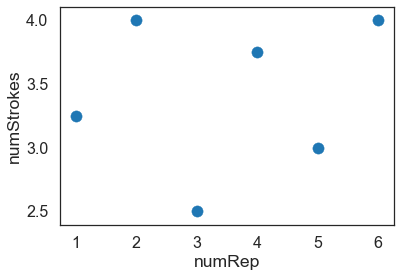

In [222]:
#numStrokes - just focusing on numStrokes to see efficacy of bonusmeter for one game
mean1 = (repeated[(repeated.loc['repetition'] == 1).index[repeated.loc['repetition'] == 1]]).loc['numStrokes'].mean()
mean2 = (repeated[(repeated.loc['repetition'] == 2).index[repeated.loc['repetition'] == 2]]).loc['numStrokes'].mean()
mean3 = (repeated[(repeated.loc['repetition'] == 3).index[repeated.loc['repetition'] == 3]]).loc['numStrokes'].mean()
mean4 = (repeated[(repeated.loc['repetition'] == 4).index[repeated.loc['repetition'] == 4]]).loc['numStrokes'].mean()
mean5 = (repeated[(repeated.loc['repetition'] == 5).index[repeated.loc['repetition'] == 5]]).loc['numStrokes'].mean()
mean6 = (repeated[(repeated.loc['repetition'] == 6).index[repeated.loc['repetition'] == 6]]).loc['numStrokes'].mean()

#control = (D[(criteria_control).index[criteria_control]])

#(D[(criteria_repeated).index[criteria_repeated]]).loc['repetition']

repeated_numStrokes = [mean1, mean2, mean3, mean4, mean5, mean6]
numRep = [1, 2, 3, 4, 5, 6]
plt.scatter(numRep, repeated_numStrokes)
plt.xlabel('numRep')
plt.ylabel('numStrokes')
fig = plt.gcf()

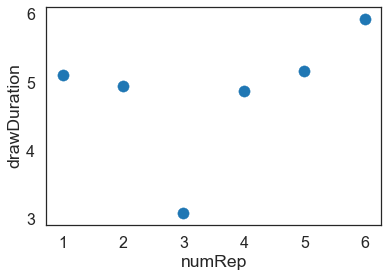

In [221]:
#drawDuration
mean1 = (repeated[(repeated.loc['repetition'] == 1).index[repeated.loc['repetition'] == 1]]).loc['drawDuration'].mean()
mean2 = (repeated[(repeated.loc['repetition'] == 2).index[repeated.loc['repetition'] == 2]]).loc['drawDuration'].mean()
mean3 = (repeated[(repeated.loc['repetition'] == 3).index[repeated.loc['repetition'] == 3]]).loc['drawDuration'].mean()
mean4 = (repeated[(repeated.loc['repetition'] == 4).index[repeated.loc['repetition'] == 4]]).loc['drawDuration'].mean()
mean5 = (repeated[(repeated.loc['repetition'] == 5).index[repeated.loc['repetition'] == 5]]).loc['drawDuration'].mean()
mean6 = (repeated[(repeated.loc['repetition'] == 6).index[repeated.loc['repetition'] == 6]]).loc['drawDuration'].mean()

repeated_drawDuration= [mean1, mean2, mean3, mean4, mean5, mean6]
numRep = [1, 2, 3, 4, 5, 6]
plt.scatter(numRep, repeated_drawDuration)
plt.xlabel('numRep')
plt.ylabel('drawDuration')
fig = plt.gcf()

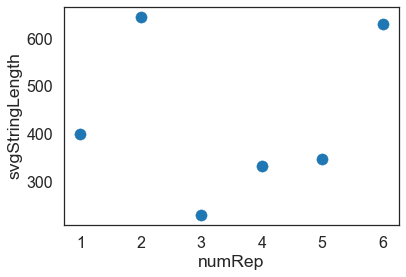

In [223]:
#svgStringLength
mean1 = (repeated[(repeated.loc['repetition'] == 1).index[repeated.loc['repetition'] == 1]]).loc['svgStringLength'].mean()
mean2 = (repeated[(repeated.loc['repetition'] == 2).index[repeated.loc['repetition'] == 2]]).loc['svgStringLength'].mean()
mean3 = (repeated[(repeated.loc['repetition'] == 3).index[repeated.loc['repetition'] == 3]]).loc['svgStringLength'].mean()
mean4 = (repeated[(repeated.loc['repetition'] == 4).index[repeated.loc['repetition'] == 4]]).loc['svgStringLength'].mean()
mean5 = (repeated[(repeated.loc['repetition'] == 5).index[repeated.loc['repetition'] == 5]]).loc['svgStringLength'].mean()
mean6 = (repeated[(repeated.loc['repetition'] == 6).index[repeated.loc['repetition'] == 6]]).loc['svgStringLength'].mean()

repeated_svgStringLength = [mean1, mean2, mean3, mean4, mean5, mean6]
numRep = [1, 2, 3, 4, 5, 6]
plt.scatter(numRep, repeated_svgStringLength)
plt.xlabel('numRep')
plt.ylabel('svgStringLength')
fig = plt.gcf()

# Miscellaneous

In [198]:
(D[(criteria_control).index[criteria_control]]).loc['numStrokes']

0    6
2    3
3    5
5    1
Name: numStrokes, dtype: object

In [197]:
(D[(criteria_control).index[criteria_control]]).loc['repetition']

0    0
2    0
3    0
5    0
Name: repetition, dtype: object

In [164]:
print repeated_strokes.mean(), control_strokes.mean()
print repeated_svgLength.mean(), control_svgLength.mean()
print repeated_svgStd.mean(), control_svgStd.mean()
print repeated_svgLengthPS.mean(), control_svgLengthPS.mean()
print repeated_drawDuration.mean(), control_drawDuration.mean()
print repeated_accuracy.mean(), control_accuracy.mean()

3.4642857142857144 3.75
431.92857142857144 457.5
63.557509910237286 34.845108478373945
118.21530612244896 171.96666666666667
5.167892857142858 6.06825
0.03571428571428571 0.25


Text(373.72,0.5,'repeated')

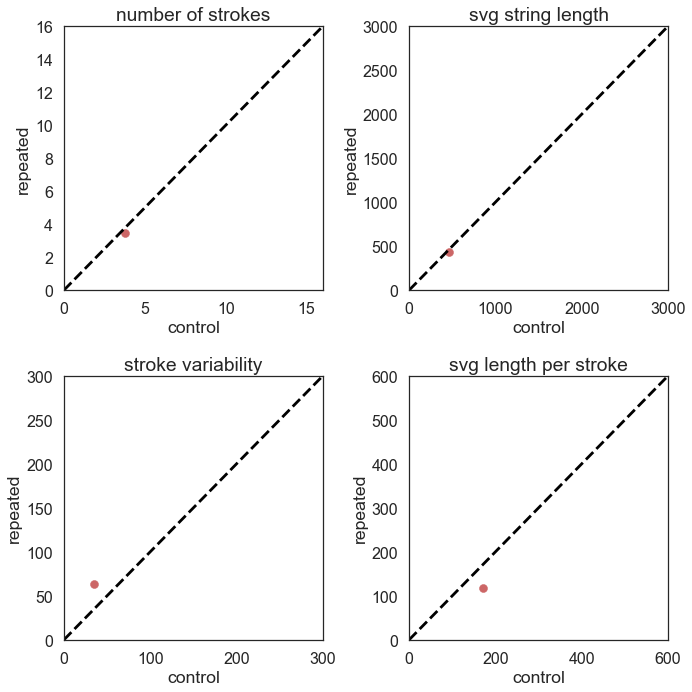

In [165]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 16
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_strokes,repeated_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLength,repeated_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgStd,repeated_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,4)
lb = 0
ub = 600
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLengthPS,repeated_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('control')
plt.ylabel('repeated')

In [21]:
a = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}, {'time':{'$gt':1531160581750, '$lt': 1531161932801}}]}).sort('time')
for rec in a:
    print rec['phase'], rec['condition'],rec['repetition']

pre repeated 0
pre repeated 0
pre control 0
pre repeated 0
pre repeated 0
pre control 0
pre control 0
pre control 0
repeated repeated 1
repeated repeated 1
repeated repeated 1
repeated repeated 1
repeated repeated 2
repeated repeated 2
repeated repeated 2
repeated repeated 2
repeated repeated 3
repeated repeated 3
repeated repeated 3
repeated repeated 3
repeated repeated 4
repeated repeated 4
repeated repeated 4
repeated repeated 4
repeated repeated 5
repeated repeated 5
repeated repeated 5
repeated repeated 5
repeated repeated 6
repeated repeated 6
repeated repeated 6
repeated repeated 6
post repeated 7
post control 1
post repeated 7
post control 1
post repeated 7
post control 1
post repeated 7
post control 1


In [32]:
rec

{u'_id': ObjectId('5b40097957ef7a16d24222a7'),
 u'assignmentId': u'3MYYFCXHJ4LKDA2T71EOLR6IEUYG49',
 u'bonus_score': u'27',
 u'clickedName': u'chihuahua',
 u'condition': u'repeated',
 u'correct': True,
 u'eventType': u'clickedObj',
 u'gameid': u'5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9',
 u'intendedName': u'chihuahua',
 u'iterationName': u'pilot2_bonusmeter',
 u'object1Name': u'chihuahua',
 u'object1SketcherLoc': 2,
 u'object1ViewerLoc': 1,
 u'object2Name': u'basset',
 u'object2SketcherLoc': 1,
 u'object2ViewerLoc': 3,
 u'object3Name': u'bullmastiff',
 u'object3SketcherLoc': 3,
 u'object3ViewerLoc': 4,
 u'object4Name': u'bloodhound',
 u'object4SketcherLoc': 4,
 u'object4ViewerLoc': 2,
 u'phase': u'repeated',
 u'pngString': u'iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AAAQO0lEQVR4Xu3dZ6xsixQH8D8P0TtBIqK3J4L4oPdOiN4J4YM83UP4oESiRpcgahCCJ4jgKdFLwtPrI0gQvfcuK/ZNJtvcc2fezNl3r5nfTk7Ouefs2XvNb637z8yePXvOFAsBAgSaCJypSZ3KJECAQASWISBAoI2AwGrTKoUSICCwzAABAm0EBFabVimUAAGBZQYIEGgjILDatEqhBAgILDNA